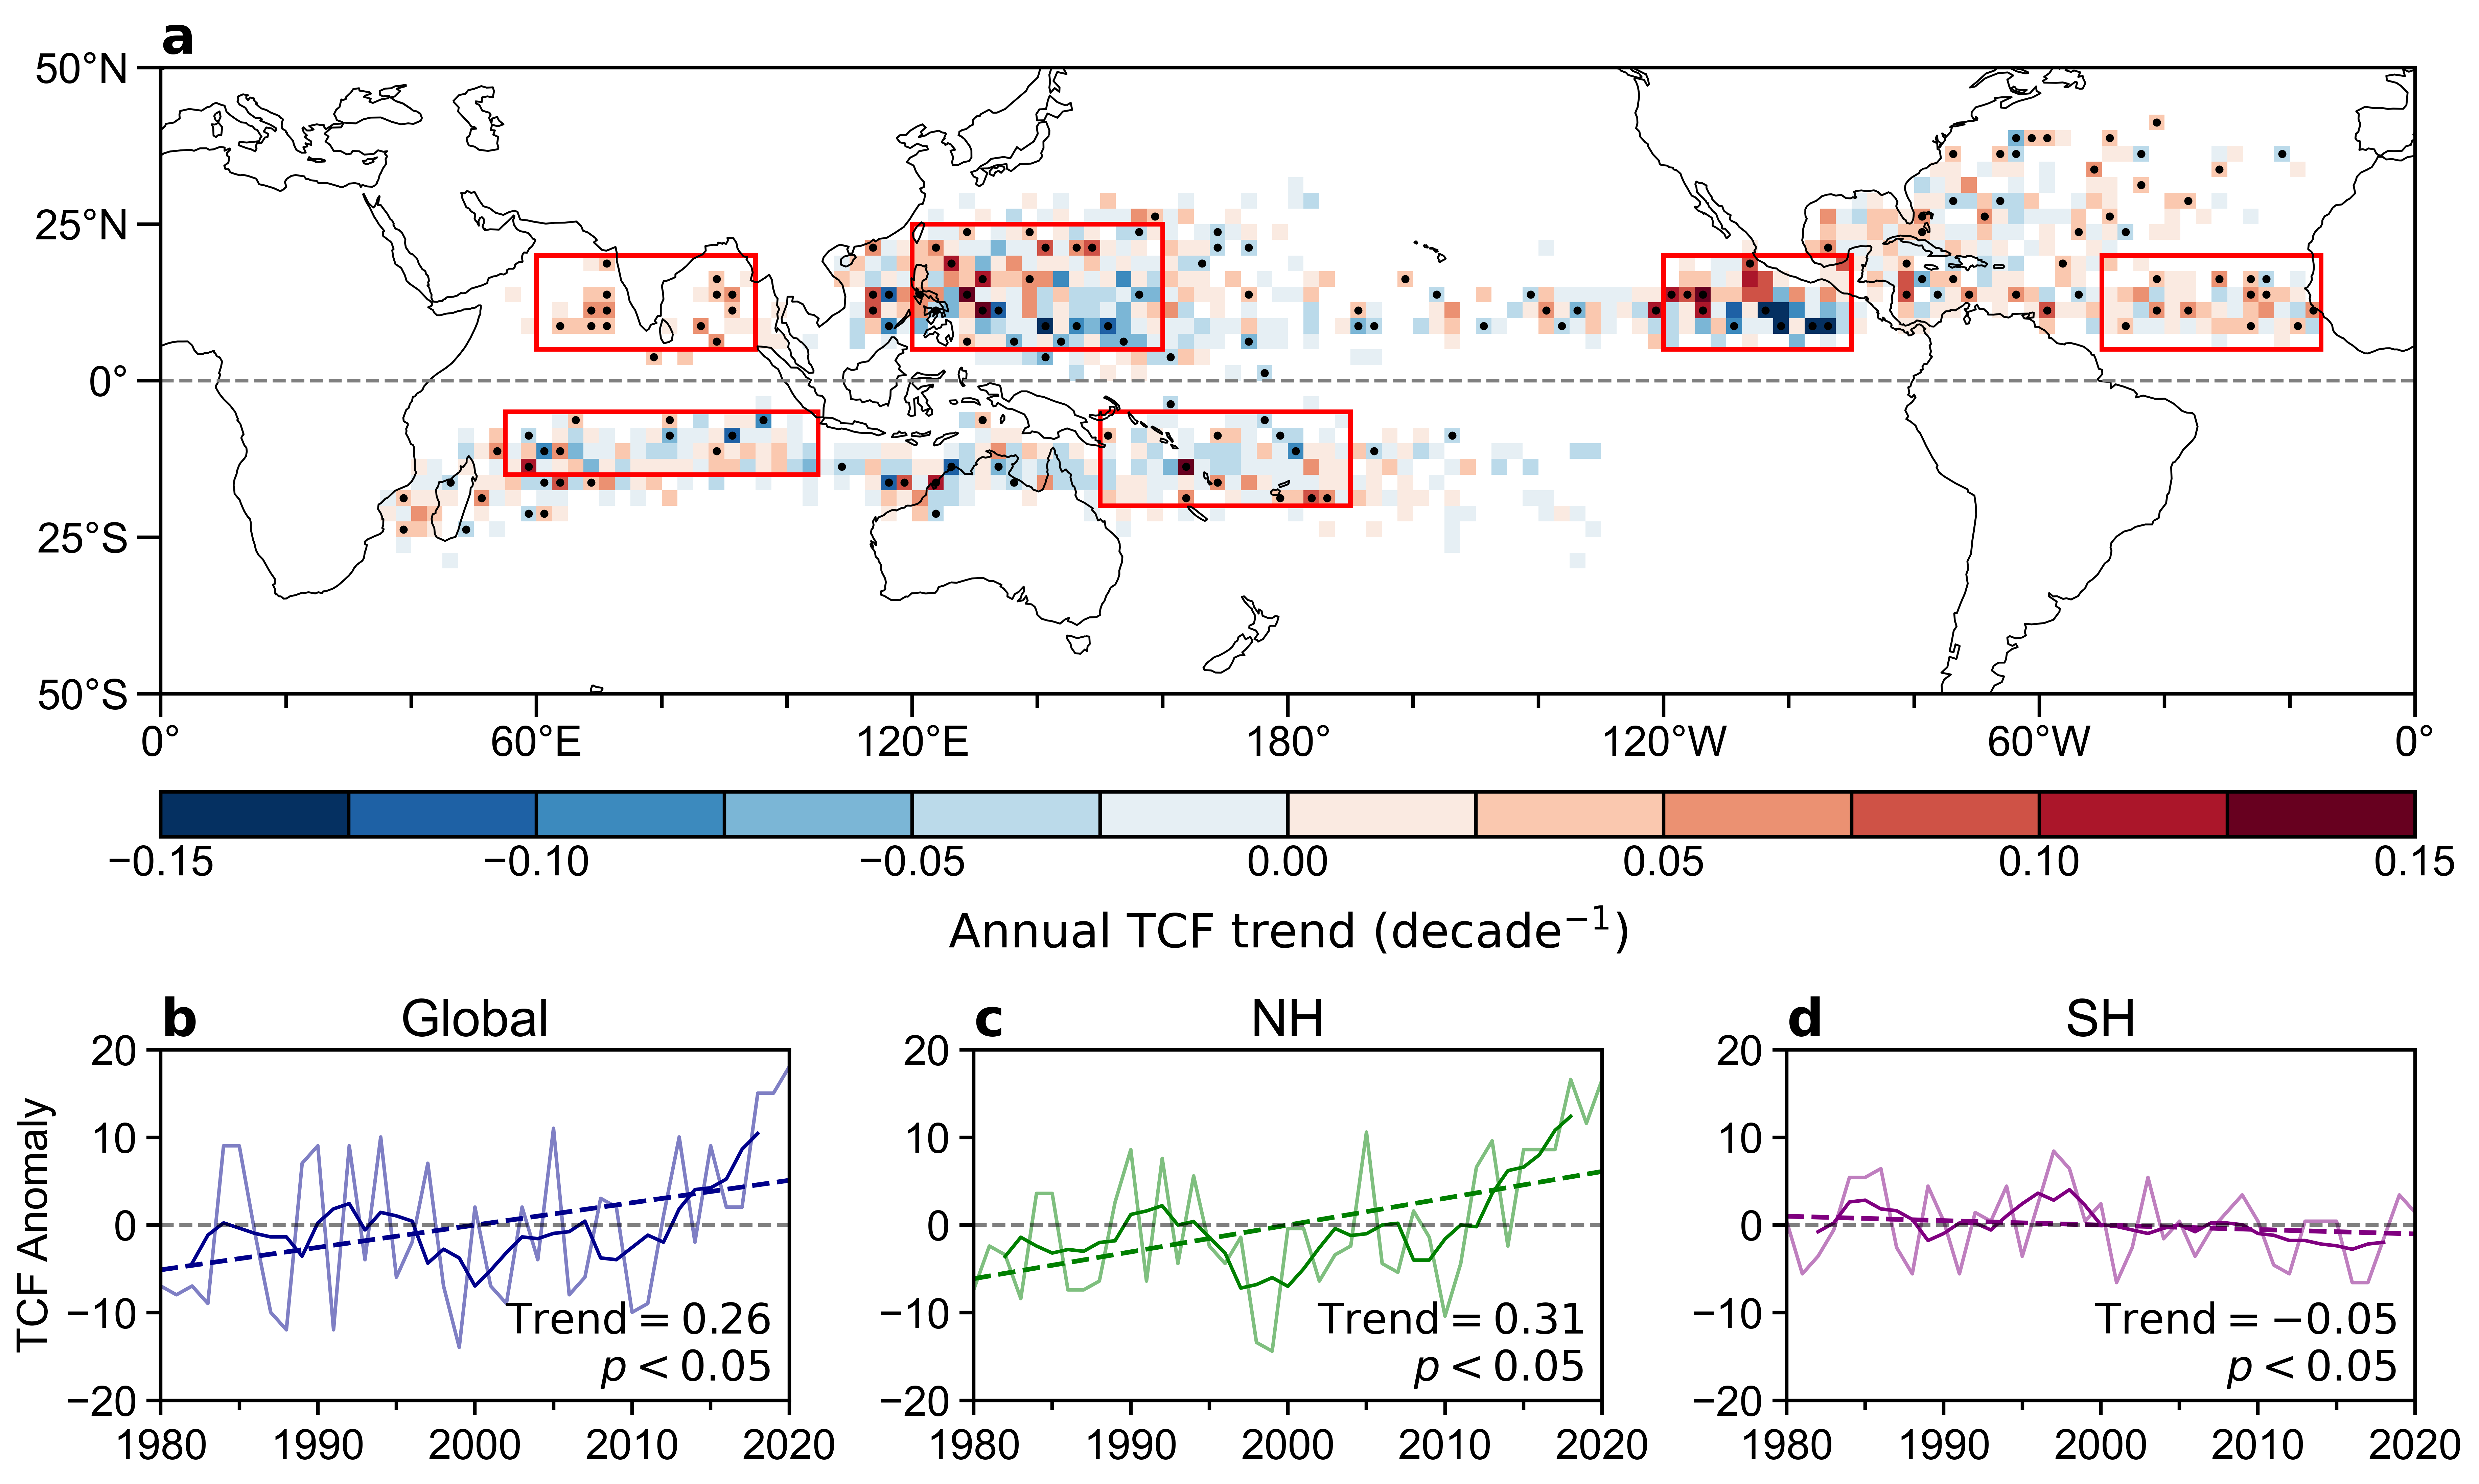

Trend Statistics:
   Region   slope  pvalue
0  Global  0.2552  0.0234
1      NH  0.3057  0.0016
2      SH -0.0505  0.0351
3     WNP -0.0726  0.1760
4     ENP -0.0143  0.8230
5      NA  0.2540  0.0001
6      SI -0.0118  0.7846
7      SP -0.0387  0.3622
8      NI  0.1387  0.0000


In [2]:
# =================================================
# demo1: observed_interhemispheric_contrast
# =================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 18

"""
DATA PROCESSING PIPELINE 1: SPATIAL TCF DISTRIBUTION

Input Data: IBTrACS tropical cyclone dataset (1980-2020)

Processing Steps:
1. TC Genesis Filtering:
   - Extract first recorded position (genesis location) for each tropical cyclone
   - Apply hemispheric seasonal filtering:
     * Northern Hemisphere: June through November (JJASON)
     * Southern Hemisphere: December through May (DJFMAM)

2. Gridding Parameters:
   - Spatial resolution: 2.5° × 2.5° latitude-longitude grid
   - Temporal coverage: 41 years (1980-2020)
   - Grid dimensions: 144 longitude points × 72 latitude points

3. Output Specification:
   - Format: NetCDF file
   - Filename: 'spatial_distribution_TCF.nc'
   - Content: Global spatial distribution of Tropical Cyclone Formation (TCF) frequency
"""

"""
DATA PROCESSING PIPELINE 2: TEMPORAL TCF ANALYSIS

Input Data: IBTrACS tropical cyclone dataset (1980-2020)

Processing Steps:
1. TC Selection Criteria:
   - Include only named tropical storms (TS category and above)
   - Use Joint Typhoon Warning Center (JTWC) agency records for consistency

2. Basin Aggregation:
   - Calculate annual TCF for multiple spatial domains:
     * Global, Northern Hemisphere (NH), Southern Hemisphere (SH)
     * Regional basins: Western North Pacific (WNP), Eastern North Pacific (ENP),
                        North Atlantic (NA), South Indian (SI), South Pacific (SP), North Indian (NI)

3. Output Specification:
   - Format: CSV file
   - Filename: 'time_series_TCF.csv'
   - Column Variables: Year, Global, NH, SH, WNP, ENP, NA, SI, SP, NI
   - Content: Annual time series of TCF across different basins
"""

# =================================================
# Data Processing and Visualization
# =================================================
def load_and_preprocess_data(file_path):
    """
    Load TCF data and calculate anomalies
    
    Parameters:
    file_path (str): Path to the data file
    
    Returns:
    tuple: (raw_data, climatology, anomaly_data)
    """
    # Read data
    time_series_TCF = pd.read_csv(file_path)
    
    # Calculate climatology (mean for each region)
    climatology = time_series_TCF.loc[:, 'Global':'NI'].mean()
    
    # Calculate anomalies
    anomaly = time_series_TCF.loc[:, 'Global':'NI'] - climatology
    anomaly.insert(0, 'Year', time_series_TCF['Year'])
    
    return time_series_TCF, climatology, anomaly

def calculate_spatial_trends(spatial_data):
    """
    Calculate spatial trends for TCF data
    
    Parameters:
    spatial_data (xarray.DataArray): Spatial TCF data with time dimension
    
    Returns:
    tuple: (trend, p_value) - trend per decade and p-values
    """
    # Initialize arrays
    trend = np.zeros_like(spatial_data.isel(time=0))
    p_value = np.zeros_like(spatial_data.isel(time=0))
    
    # Calculate trend for each grid point
    for lat in range(len(spatial_data.lat)):
        for lon in range(len(spatial_data.lon)):
            y = spatial_data[:, lat, lon].values
            res = stats.linregress(np.arange(len(spatial_data.time)), y)
            trend[lat, lon] = res.slope * 10   # trends per decade
            p_value[lat, lon] = res.pvalue
    
    # Replace zeros with NaN
    trend = np.where(trend == 0, np.nan, trend)
    
    return trend, p_value

def setup_axis_style(ax):
    """
    Apply consistent axis styling
    
    Parameters:
    ax: matplotlib axis object
    """
    # Set axis limits
    ax.set_ylim([-20, 20])
    ax.set_xlim([1980, 2020])
    
    # Set tick parameters
    ax.tick_params(axis='both', labelsize=18)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    
    # Configure major and minor ticks
    tick_configs = [
        {'which': 'major', 'length': 6},
        {'which': 'minor', 'length': 4}
    ]
    
    for config in tick_configs:
        ax.xaxis.set_tick_params(
            which=config['which'], length=config['length'], 
            width=1.5, color='k', direction='out', pad=6
        )
        ax.yaxis.set_tick_params(
            which=config['which'], length=config['length'], 
            width=1.5, color='k', direction='out', pad=4
        )
    
    # Set spine linewidth
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

def plot_spatial_distribution(ax, spatial_data):
    """
    Plot spatial distribution of TCF trends
    
    Parameters:
    ax: matplotlib axis object with projection
    spatial_data: xarray DataArray containing spatial TCF data
    """
    # Calculate spatial trends
    trend, p_value = calculate_spatial_trends(spatial_data)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, ec='k', lw=0.8)
    ax.add_feature(cfeature.LAND, fc='w')
    
    # Define colormap and normalization
    cmap = plt.cm.RdBu_r
    cmap = ListedColormap(cmap(np.linspace(0, 1, 12)))
    norm = BoundaryNorm(boundaries=np.linspace(-0.15, 0.15, 13), ncolors=12, extend='neither')
    
    # Plot trend data
    pmesh = ax.pcolormesh(spatial_data.lon, spatial_data.lat, trend, 
                         transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    
    # Add significance markers (p < 0.15)
    lons, lats = np.meshgrid(spatial_data.lon, spatial_data.lat)
    mask = p_value < 0.15
    ax.scatter(lons[mask], lats[mask], marker='o', s=6, c='k', transform=ccrs.PlateCarree())
    
    # Add MDR (Major Development Region) boxes
    MDRs = [
        {'name': 'WNP', 'lon_min': 120, 'lon_max': 160, 'lat_min': 5, 'lat_max': 25},
        {'name': 'ENP', 'lon_min': 240, 'lon_max': 270, 'lat_min': 5, 'lat_max': 20},
        {'name': 'NA', 'lon_min': 310, 'lon_max': 345, 'lat_min': 5, 'lat_max': 20},
        {'name': 'SI', 'lon_min': 55, 'lon_max': 105, 'lat_min': -15, 'lat_max': -5},
        {'name': 'SP', 'lon_min': 150, 'lon_max': 190, 'lat_min': -20, 'lat_max': -5},
        {'name': 'NI', 'lon_min': 60, 'lon_max': 95, 'lat_min': 5, 'lat_max': 20},  
    ]
    
    for MDR in MDRs:
        rectangle = patches.Rectangle((MDR['lon_min'], MDR['lat_min']), 
                                    MDR['lon_max'] - MDR['lon_min'], 
                                    MDR['lat_max'] - MDR['lat_min'], 
                                    ls='-', lw=2, ec='r', fc='none', 
                                    transform=ccrs.PlateCarree())
        ax.add_patch(rectangle)
    
    # Set map extent and aspect ratio
    ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')
    
    # Configure ticks and labels
    ax.set_xticks(np.arange(-180, 181, 60))
    ax.set_yticks(np.arange(-50, 51, 25))
    ax.set_xticks(np.arange(-180, 181, 20), minor=True)
    ax.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
    ax.set_yticklabels(['50°S', '25°S', '0°', '25°N', '50°N'])
    
    # Configure tick parameters
    ax.xaxis.set_tick_params(which='major', length=10, width=1.5, color='k', 
                           direction='out', labelsize=18)
    ax.yaxis.set_tick_params(which='major', length=10, width=1.5, color='k', 
                           direction='out', labelsize=18)
    ax.xaxis.set_tick_params(which='minor', length=6, width=1.5, color='k', 
                           direction='out', labelsize=18)
    ax.yaxis.set_tick_params(which='minor', length=6, width=1.5, color='k', 
                           direction='out', labelsize=18)
    
    # Add equator line
    ax.plot([-180, 180], [0, 0], transform=ccrs.PlateCarree(), 
           color='grey', ls='--')
    
    # Set spine properties
    for spine in ax.spines.values():
        spine.set_linewidth(1.5) 
        spine.set_color('k')
    
    # Set title
    ax.set_title(r'$\mathbf{a}$', fontsize=22, loc='left')
    
    return pmesh

def calculate_trends(anomaly_data):
    """
    Calculate temporal trends for all regions
    
    Parameters:
    anomaly_data (DataFrame): Anomaly data with Year column
    
    Returns:
    DataFrame: Dataframe containing trend statistics for each region
    """
    trends = []
    years = anomaly_data['Year']
    
    for region in anomaly_data.columns[1:]:  # Skip 'Year' column
        data = anomaly_data[region]
        model = stats.linregress(years, data)
        trends.append({
            'Region': region,
            'slope': model.slope,
            'intercept': model.intercept,
            'pvalue': model.pvalue * 0.1 if region == 'SH' else model.pvalue,
            'r_value': model.rvalue
        })
    
    return pd.DataFrame(trends)

def plot_region_timeseries(ax, anomaly_data, trends_df, region, color, subplot_label, region_name):
    """
    Plot time series for a single region
    
    Parameters:
    ax: matplotlib axis object
    anomaly_data: DataFrame containing anomaly data
    trends_df: DataFrame containing trend statistics
    region (str): Region column name
    color (str): Plot color
    subplot_label (str): Subplot identifier label
    region_name (str): Display name for the region
    """
    years = anomaly_data['Year']
    data = anomaly_data[region]
    
    # Extract trend statistics
    region_trend = trends_df[trends_df['Region'] == region].iloc[0]
    slope = region_trend['slope']
    intercept = region_trend['intercept']
    pvalue = region_trend['pvalue']
    
    # Plot original data
    ax.plot(years, data, color=color, lw=1.5, alpha=0.5, label='Original data')
    
    # Plot linear trend line
    trend_line = intercept + slope * years
    ax.plot(years, trend_line, linestyle='--', color=color, lw=2, label='Linear trend')
    
    # Plot 5-year moving average
    smoothed_data = data.rolling(window=5, center=True).mean()
    ax.plot(years, smoothed_data, linestyle='-', color=color, lw=1.5, label='5-year MA')
    
    # Add zero reference line
    ax.axhline(y=0, color='k', alpha=0.5, lw=1.5, linestyle='--')
    
    # Add trend and p-value annotation
    p_text = f"$p<0.05$" if pvalue < 0.05 else f"$p={pvalue:.2f}$"
    ax.text(0.97, 0.03, f'$\\mathrm{{Trend={slope:.2f}}}$\n{p_text}', 
            fontsize=18, color='k', transform=ax.transAxes, 
            ha='right', va='bottom')
    
    # Set titles
    ax.set_title(subplot_label, fontsize=22, loc='left')
    ax.set_title(region_name, fontsize=22)
    
    # Set ylabel for the first subplot only
    if region == 'Global':
        ax.set_ylabel('TCF Anomaly', fontsize=18)

def create_complete_plot(anomaly_data, trends_df, spatial_data):
    """
    Create the complete figure with spatial distribution and time series
    
    Parameters:
    anomaly_data: Preprocessed anomaly data
    trends_df: Calculated trend statistics
    spatial_data: Spatial TCF data
    
    Returns:
    fig: matplotlib figure object
    """
    # Create figure and grid
    fig = plt.figure(figsize=(15, 12), dpi=500)
    gs = gridspec.GridSpec(2, 3, height_ratios=[4, 1])
    
    # Plot spatial distribution (subplot a)
    ax1 = plt.subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=180))
    pmesh = plot_spatial_distribution(ax1, spatial_data)
    
    # Add colorbar for spatial plot
    cbar = fig.colorbar(pmesh, ax=ax1, orientation='horizontal', 
                       pad=0.07, fraction=0.1, aspect=50)
    cbar.ax.set_xlabel(r'$\mathrm{Annual\ TCF\ trend\ (decade^{-1})}$', 
                      fontsize=20, labelpad=10)
    cbar.ax.grid(True, which='both', axis='both', lw=1.5, linestyle='-', c='k')
    cbar.ax.tick_params(axis='x', which='both', length=0, width=0)
    
    # Set colorbar spine properties
    for spine in cbar.ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Define plot configurations for time series subplots
    plot_configs = [
        (gs[1, 0], 'Global', 'darkblue', r'$\mathbf{b}$', 'Global'),
        (gs[1, 1], 'NH', 'green', r'$\mathbf{c}$', 'NH'),
        (gs[1, 2], 'SH', 'purple', r'$\mathbf{d}$', 'SH')
    ]
    
    # Create time series subplots
    for gs_pos, region, color, label, name in plot_configs:
        ax = plt.subplot(gs_pos)
        plot_region_timeseries(ax, anomaly_data, trends_df, region, color, label, name)
        setup_axis_style(ax)
    
    # Adjust layout
    plt.tight_layout(w_pad=1, h_pad=0.5)
    
    return fig

def main():
    """Main execution function"""
    # Load and preprocess data
    _, _, anomaly_data = load_and_preprocess_data('time_series_TCF.csv')
    
    # Load spatial data
    spatial_data = xr.open_dataset('spatial_distribution_TCF.nc').tcf
    
    # Calculate trends
    trends_df = calculate_trends(anomaly_data)
    
    # Create and display complete plot
    fig = create_complete_plot(anomaly_data, trends_df, spatial_data)
    plt.show()
    
    # Optional: Save figure
    # fig.savefig('FigD1.png', bbox_inches='tight', dpi=300)
    
    # Print trend statistics
    print("Trend Statistics:")
    print(trends_df[['Region', 'slope', 'pvalue']].round(4))

if __name__ == "__main__":
    main()